August: Defining transport sections on the plane that cuts vertically at the shelf break. This is specifically for V transport.

In [7]:
import numpy as np
import netCDF4 as nc
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

## Key variables:
* gdepv: depth of V-grid points
* vmask: mask for V-grid
* mbathy: fortran (1-based) index of deepest water cell, T-grid
* e1v: 	grid spacing on V-grid in u direction
* e3v
* note: the cross section at the shelf break plane is looking out of the canyon from the inside.

In [8]:
def get_variables_V(dirname, filename):
    with nc.Dataset(os.path.join(dirname, filename), 'r') as nbl:
        x, y =  slice(1,-1,None), slice(1,-1,None)
        gdepv = nbl.variables['gdepv'][0, :, 1, 1]
        vmask = nbl.variables['vmask'][0, :, y, x]
        mbathy = nbl.variables['mbathy'][0, y, x]
        e1v = nbl.variables['e1v'][0, y, x]
        e3v_0 = nbl.variables['e3v_0'][0, :, y, x]  
        return gdepv, vmask, mbathy, e1v, e3v_0

In [26]:
def get_indices_V(gdepv, vmask, mbathy, e1v, e3v_0):
    
    # z index of the shelf platform
    # 1. find where the depth of v point is closest to 80
    # 2. re-assess answer later
    ind_shelf = np.argmin(np.abs(gdepv - 80))

    # y index of shelf break 
    # 1. get top view of vmask at shelf depth
    # 2. extract wet/dry values along x=1 
    # 3. find the first wet cell
    ind_plane = np.where(vmask[ind_shelf, :, 1] == 1)[0][0]

    print('ind_plane', ind_plane)

    # z index of the shelf platform
    cells_shelf = vmask[ind_shelf, ind_plane, :]
    cells_shelf_W = np.count_nonzero(cells_shelf)
    cells_shelf_D = vmask.shape[-1] - cells_shelf_W
    while cells_shelf_D < 4:
        ind_shelf += 1
        cells_shelf = vmask[ind_shelf, ind_plane, :]
        cells_shelf_W = np.count_nonzero(cells_shelf)
        cells_shelf_D = vmask.shape[-1] - cells_shelf_W
    depth_shelf = gdepv[ind_shelf]

    print('ind_shelf', ind_shelf)
    print('depth_shelf', depth_shelf)

    # z index of canyon bottom
    # 1. mbathy gives maximum depth level everywhere
    # 2. this value is given in fortran indexing
    # 3. subtracting 1 gives the deepest level with wet cells
    ind_bottom = (mbathy[ind_plane,:].max())-1
    depth_bottom = gdepv[ind_bottom]

    print('ind_bottom', ind_bottom)
    print('depth_bottom', depth_bottom)

    # x index of canyon axis
    # 1. find all wet cells along canyon bottom
    # 2. find the middle wet cell for symmetric axis
    # 3. this could have a 0.5 so return integer

    ind_axis = int(np.median(np.where(vmask[ind_bottom, ind_plane, :]==1)))
    print('ind_axis', ind_axis)

    # x index of rims
    # 1. last land value on left
    # 2. first land value on right
    ind_rimL0 = np.where(vmask[ind_shelf, ind_plane, :ind_axis]==0)[0][-1]
    ind_rimR0 = np.where(vmask[ind_shelf, ind_plane, ind_axis:]==0)[0][0] + ind_axis
    axis_to_rim = min(ind_rimR0 - ind_axis, ind_axis - ind_rimL0)
    ind_rimL = ind_axis - axis_to_rim
    ind_rimR = ind_axis + axis_to_rim

    print('ind_rimL', ind_rimL)
    print('ind_rimR', ind_rimR)

    # z index of half canyon
    # 1. area of individual wet cells
    cell_x_j = e1v[ind_plane, :]
    cell_y_j = e3v_0[:, ind_plane, :]
    area_j = vmask[:, ind_plane, :] * cell_x_j * cell_y_j

    # 2. total area of every depth level
    area_all = np.zeros(area_j.shape[0])
    for depth_ind in range(area_j.shape[0]):
        area_all[depth_ind] = area_j[depth_ind, :].sum()

    # 3. areas and indices of only the depth levels inside the canyon
    area_canyon = area_all[ind_shelf:ind_bottom]
    area_canyon_inds = np.arange(ind_shelf,ind_bottom)

    # 4. half the area of the canyon
    total_area_canyon = np.sum(area_canyon)
    half_area_canyon = total_area_canyon / 2

    # 5. relative level where cumulative area is closest to the half area
    cumsum_area_canyon = np.cumsum(area_canyon)
    relative_ind_half = (np.abs(cumsum_area_canyon-half_area_canyon)).argmin()

    # 6. the real depth level for half area
    ind_half = area_canyon_inds[relative_ind_half]
    depth_half = gdepv[ind_half]

    print('ind_half', ind_half)
    print('depth_half', depth_half)
    
    # x index of shelves
    ind_shfL0 = 10
    ind_shfR0 = vmask.shape[-1] - 10
    axis_to_shf = min(ind_shfR0 - ind_axis, ind_axis - ind_shfL0)
    ind_shfL = ind_axis - axis_to_shf
    ind_shfR = ind_axis + axis_to_shf

    print('ind_shfL', ind_shfL)
    print('ind_shfR', ind_shfR)
    
    return ind_plane, ind_shelf, ind_bottom, ind_axis, ind_rimL, ind_rimR, ind_half, ind_shfL, ind_shfR,\
            depth_shelf, depth_bottom, depth_half, area_j

In [27]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
filename = '1_mesh_mask.nc'

gdepv, vmask, mbathy, e1v, e3v_0 = get_variables_V(dirname, filename)

gdepv.shape, vmask.shape, mbathy.shape, e1v.shape, e3v_0.shape

((80,), (80, 272, 242), (272, 242), (272, 242), (80, 272, 242))

In [28]:
ind_plane, ind_shelf, ind_bottom, ind_axis, ind_rimL, ind_rimR, ind_half, ind_shfL, ind_shfR,\
depth_shelf, depth_bottom, depth_half, area_j = get_indices_V(gdepv, vmask, mbathy, e1v, e3v_0)

ind_plane 178
ind_shelf 10
depth_shelf 91.875
ind_bottom 60
depth_bottom 534.672
ind_axis 110
ind_rimL 48
ind_rimR 172
ind_half 25
depth_half 223.125
ind_shfL 10
ind_shfR 210


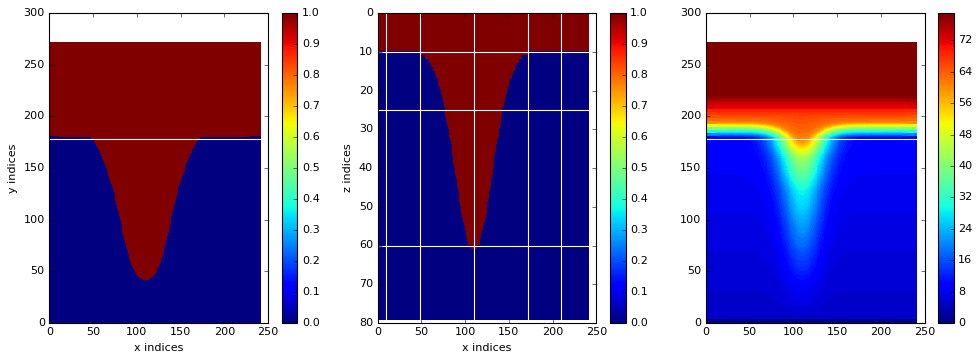

In [31]:
xs = np.arange(vmask.shape[-1])
ys = np.arange(vmask.shape[-2])
zs = np.arange(vmask.shape[-3])

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
p1 = ax1.pcolor(xs, ys, vmask[ind_shelf, :, :])
p2 = ax2.pcolor(xs, zs, vmask[:, ind_plane, :])
p3 = ax3.pcolor(xs, ys, mbathy)
fig.colorbar(p1, ax=ax1)
fig.colorbar(p2, ax=ax2)
fig.colorbar(p3, ax=ax3)
ax2.invert_yaxis()

ax1.axhline(ind_plane, c='white')
ax2.axhline(ind_shelf, c='white')
ax2.axhline(ind_bottom, c='white')
ax2.axvline(ind_axis, c='white')
ax3.axhline(ind_plane, c='white')
ax2.axvline(ind_rimL, c='white')
ax2.axvline(ind_rimR, c='white')
ax2.axhline(ind_half, c='white')
ax2.axvline(ind_shfL, c='white')
ax2.axvline(ind_shfR, c='white')

ax1.set_xlabel('x indices')
ax1.set_ylabel('y indices')
ax2.set_xlabel('x indices')
ax2.set_ylabel('z indices')